# Getting started with Bruges

This notebook accompanies [a blog post on agilegeoscience.com](http://www.agilegeoscience.com/blog/). 

You need to install Bruges to run this notebook. You can clone the repository on GitHub or if you have pip installed, in a terminal you can do,

    pip install bruges

This notebook also requires Striplog, which you can install like so:

    pip install striplog

In [1]:
import bruges as b
b.__version__

'0.2.1'

<hr />

## AVO calculations

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |  
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [2]:
# Upper layer rock properties
vp1 = 3300.0
vs1 = 1500.0
rho1 = 2400.0

# Lower layer rock properties
vp2 = 3050.0
vs2 = 1400.0
rho2 = 2075.0

In [3]:
rc_0 = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0)
rc_0

-0.11199577706417983

In [4]:
rc_30 = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1=30)
rc_30

-0.096520698009549363

We can also get the individual terms of Shuey's linear approximation:

In [5]:
rc_terms = b.reflection.shuey2(vp1, vs1, rho1, vp2, vs2, rho2, theta1=30, terms=True)
rc_terms

(-0.11199577706417983, 0.019688936025916742)

The second term is the product of gradient and $sin^2 \theta$. So we can compute the gradient from this:

In [6]:
import numpy as np

intercept = rc_terms[0]
gradient = rc_terms[1] / np.sin(np.radians(30))**2
intercept, gradient

(-0.11199577706417983, 0.07875574410366698)

We can pass in a list of angles,

In [7]:
theta_list = [0, 10, 20, 30]
rc_list = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1=theta_list)
rc_list

array([-0.11199578, -0.10982911, -0.10398651, -0.0965207 ])

Create an array of angles from 0 to 70, incremented by 1,

In [8]:
theta_range = np.arange(0, 70)

Create some variables for our data so we don't have to type so much

In [9]:
rc_range = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta_range)

Compare the two-term Aki-Richards approximation with the full Zoeprittz equation for a interface between two rocks:

In [10]:
rc_z = b.reflection.zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta_range)

Put all this data on an AVO plot:

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

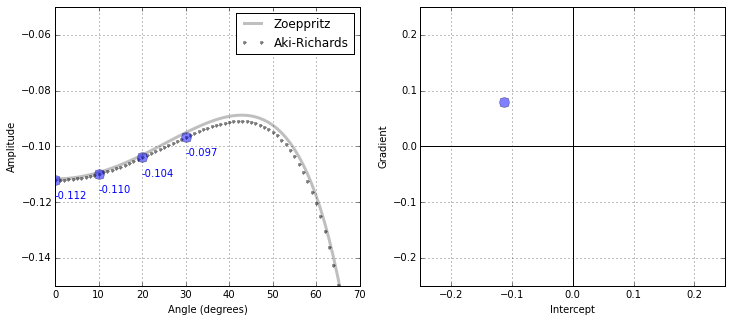

In [12]:
style = {'color': 'blue',
         'fontsize': 10,
         'ha':'left',
         'va':'top',}

fig = plt.figure(figsize=(12,5))

# AVO plot
ax1 = fig.add_subplot(121)
ax1.plot(theta_range, rc_z, 'k', lw=3, alpha=0.25, label='Zoeppritz')
ax1.plot(theta_range, rc_range, 'k.', lw=3, alpha=0.5, label='Aki-Richards')

# We'll also add the four angles...
ax1.plot(theta_list, rc_list, 'bo', ms=10, alpha = 0.5)

# Putting some annotations on the plot.
for theta, rc in zip(theta_list, rc_list):
    ax1.text(theta, rc-0.004, '{:.3f}'.format(rc), **style)

ax1.legend()
ax1.set_ylim((-0.15, -0.05))
ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Amplitude')
ax1.grid()

# Intercept-Gradient crossplot.
ax2 = fig.add_subplot(122)
ax2.plot(intercept, gradient, 'bo', ms=10, alpha = 0.5)

# Put spines for x and y axis.
ax2.axvline(0, color='k')
ax2.axhline(0, color='k')

# Set square axes limits.
mx = 0.25
ax2.set_xlim((-mx, mx))
ax2.set_ylim((-mx, mx))

# Label the axes and add gridlines.
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Gradient')
ax2.grid()

plt.show()

<hr />

## Elastic moduli calculations

Say I want to compute the Lamé parameters &#955; and &#181;, from V<sub>P</sub>, V<sub>S</sub>, and Density. As long as my inputs are in SI units, I can insert these values directly:

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [13]:
# Upper layer only
b.rockphysics.lam(vp1, vs1, rho1), b.rockphysics.mu(vp1, vs1, rho1)

(15336000000.0, 5400000000.0)

We can print all the values in terms of GPa ($\times 10^9$ Pa)

In [14]:
print('Upper layer')
print('lambda [GPa]: {:.2f}'.format(b.rockphysics.lam(vp1, vs1, rho1) / 1e9))
print('    mu [GPa]: {:.2f}'.format(b.rockphysics.mu(vp1, vs1, rho1) / 1e9))
print('\nLower layer')
print('lambda [GPa]: {:.2f}'.format(b.rockphysics.lam(vp2, vs2, rho2) / 1e9))
print('    mu [GPa]: {:.2f}'.format(b.rockphysics.mu(vp2, vs2, rho2) / 1e9))

Upper layer
lambda [GPa]: 15.34
    mu [GPa]: 5.40

Lower layer
lambda [GPa]: 11.17
    mu [GPa]: 4.07


<hr />

## Rock property analysis and crossplotting

In [15]:
import striplog
striplog.__version__

'0.5.6'

In [16]:
from striplog import Well

In [17]:
well = Well('data/P-132_synth.las', null_subs=np.nan)

# Crop the log to first and last RHOB samples, where the data is:
rhob, dt, z = b.util.top_and_tail(well.data['RHOB_despiked'], well.data['Sonic_despiked'], well.data['DEPT'])

Convert everything to SI units:

In [18]:
vp =  1e6 / (3.28084 * dt)
vs = (vp - 1360)/1.16  # Castanga model
rhob *= 1000

In [19]:
lm_log = b.rockphysics.lam(vp, vs, rhob)
mu_log = b.rockphysics.mu(vp, vs, rhob)

Create a crossplot:

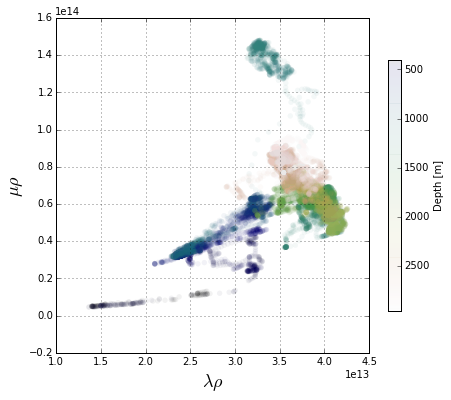

In [20]:
plt.figure(figsize=(7,6))
plt.scatter(lm_log*rhob, mu_log*rhob, s=30, c=z, cmap="gist_earth",
            edgecolor='none',  # marker edge color
            alpha = 0.05)

# Give the plot a colorbar.
cb = plt.colorbar(shrink=0.75)
cb.ax.invert_yaxis()  # put shallow colors at the top
cb.set_ticks([500,1000,1500,2000,2500,3000])
cb.set_label("Depth [m]")

# Give the plot some annotation.
plt.xlabel(r'$\lambda \rho$', size=18)
plt.ylabel(r'$\mu \rho$', size=18)
plt.grid()

<hr />

## Backus averaging

In [21]:
lb = 60       # Backus averaging length in metres.
dz = 0.1524   # Sample interval of the log in metres.

In [22]:
vp0, vs0 = b.rockphysics.backus(vp, vs, rhob, lb, dz)

In [23]:
vp0

array([ 3031.59356981,  3030.93577466,  3030.26551065, ...,  5255.48971727,
        5254.83711919,  5254.18638595])

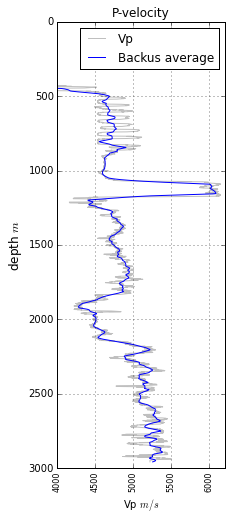

In [24]:
fs = 8  # control the fontsize

fig = plt.figure(figsize=(3,8))

ax1 = plt.subplot(111)
ax1.plot(vp, z, 'k', alpha=0.25, label='Vp')
ax1.plot(vp0, z, 'b', label='Backus average')

# Do some plot annotations
ax1.set_title('P-velocity')
ax1.set_ylabel(r'depth $m$', size=12)
ax1.invert_yaxis()
ax1.set_xlim((4000,6200))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
ax1.legend()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="40px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>